# Reversible Network Reconnection Model

Attempt at implementing the RNR model as described in Okuda et al. 2012:

>_Reversible network reconnection model for simulating large deformation in dynamic tissue morphogenesis_, Satoru Okuda, Yasuhiro Inoue, Mototsugu Eiraku, Yoshiki Sasai and Taiji Adachi Biomech Model Mechanobiol (2013) 12:627–644 [DOI 10.1007/s10237-012-0430-7](http://link.springer.com/article/10.1007%2Fs10237-012-0430-7)


The authors give 4 conditions which we detail and implement bellow.




## Condition 1 - Center of a face

The center of a face is defined by the average position of the face's edges midpoints, weighted by their lengths.

$$ \mathbf{r}_{\alpha} = \frac{\sum_{ij\alpha}\ell_{ij} (\mathbf{r}_i + \mathbf{r}_j)/2}{\sum_{ij\alpha}\ell_{ij}}$$


In [1]:
import numpy as np, pandas as pd
import ipyvolume as ipv
import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import Epithelium
from tyssue import BulkGeometry, RNRGeometry
from tyssue import Sheet
from tyssue.config.geometry import bulk_spec
from tyssue.generation import three_faces_sheet
from tyssue.generation import extrude
from tyssue.draw import sheet_view, highlight_cells

from tyssue.topology.bulk_topology import IH_transition, HI_transition



draw_spec = {'face': {'visible': True}}




sheet = Sheet.planar_sheet_3d('sheet', 5, 5, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')

eptm = Epithelium('20faces_3D', datasets, bulk_spec())
eptm.vert_df[eptm.coords] += np.random.normal(scale=1e-2, size=(eptm.Nv, 3))
RNRGeometry.update_all(eptm)
RNRGeometry.center(eptm)
RNRGeometry.update_all(eptm)


eptm.settings['threshold_length'] = 1e-4
print(eptm.Nf, eptm.Ne, eptm.Nv)
draw_spec['face']['color'] = eptm.face_df.area
draw_spec['face']['color_range'] = (0, 1)

ipv.clear()
fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
fig

93 414 70


Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

## I→H transition

![IH transition in a bulk and a RNR](data/png/IH_transition.png)

This produces a shape similar to the one studied by LM Escudero and collegues [in their article](https://www.nature.com/articles/s41467-018-05376-1.pdf).





In [2]:
e_1011 = 26
eptm.settings['threshold_length'] = 0.2

srce, trgt, face, cell = eptm.edge_df.loc[e_1011,
                                          ['srce', 'trgt',
                                           'face', 'cell']]

IH_transition(eptm, e_1011)
RNRGeometry.update_all(eptm)

highlight_cells(eptm, cell, reset_visible=True)
draw_spec['face']['color'] = eptm.face_df.area


ipv.clear()
fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
fig

cell 0 is already closed
cell 5 is already closed


Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

# H → I transition

In [3]:
fa = 93


HI_transition(eptm, fa)
RNRGeometry.update_all(eptm)

highlight_cells(eptm, cell, reset_visible=True)
ipv.clear()
draw_spec['face']['color'] = eptm.face_df.area
draw_spec['face']['visible'] = True
eptm.face_df.visible = True
#fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
#fig

cell 4 is already closed
cell 0 is already closed
cell 5 is already closed
cell 1 is already closed


In [4]:
eptm.edge_df[eptm.edge_df['sub_vol'] <= 1e-10][["srce", "trgt", "face", "cell", "length", "sub_area", "sx", "sy", "sz", "tx", "ty", "tz", "fx", "fy", "fz"]]

srce  trgt  face  cell    length      sub_area        sx        sy  \
edge                                                                       
241     39    51    50     5  0.534805  7.372575e-18 -1.312808 -0.374665   
244     51    39    51     0  0.534805  7.564593e-18 -0.838700 -0.621678   

            sz        tx        ty        tz        fx        fy        fz  
edge                                                                        
241  -0.493168 -0.838700 -0.621678 -0.508126 -1.075754 -0.498172 -0.500647  
244  -0.508126 -1.312808 -0.374665 -0.493168 -1.075754 -0.498172 -0.500647

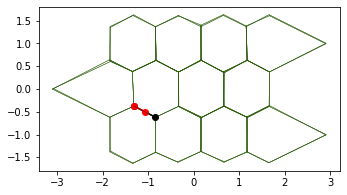

In [5]:
fig, ax = sheet_view(eptm, coords=["x", "y"])

ax.plot(eptm.edge_df.loc[241, ["sx", "tx"]], eptm.edge_df.loc[241, ["sy", "ty"]], "ko-")
ax.plot(eptm.edge_df.loc[241, ["fx", "sx"]], eptm.edge_df.loc[241, ["fy", "sy"]], "ro-")

for e, data in eptm.edge_df[eptm.edge_df.face.isin([50, 51])].iterrows():
    
    ax.plot(data[["sx", "tx"]], data[["sy", "ty"]], "k-",lw=0.2)


In [6]:
RNRGeometry.update_areas(eptm)

In [7]:
highlight_cells(eptm, cell, reset_visible=False)
ipv.clear()
draw_spec['face']['color'] = eptm.face_df.area
eptm.face_df.visible = True
#fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
#fig

### Testing for I→H / H →I transition triggers

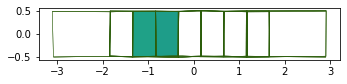

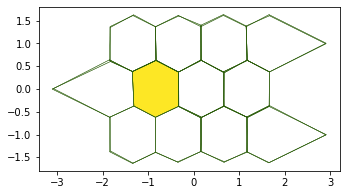

In [8]:
highlight_cells(eptm, cell, reset_visible=True)
draw_spec['face']['color'] = eptm.face_df.area


fig, ax = sheet_view(eptm, coords = ["x", "z"], **draw_spec)
fig, ax = sheet_view(eptm, coords = ["x", "y"], **draw_spec)


In [9]:
eptm.settings['threshold_length'] = 1e-3
#eptm.settings['threshold_length'] = eptm.edge_df.length.min()+1e-3

In [10]:
def find_rearangements(eptm):
    l_th = eptm.settings['threshold_length']
    up_num_sides = eptm.upcast_face(eptm.face_df['num_sides'])   
    shorts = eptm.edge_df[eptm.edge_df['length'] < l_th]
    non_triangular = up_num_sides[up_num_sides > 4 ].index
    edges_IH = set(shorts.index).intersection(non_triangular)

    max_f_length = shorts.groupby('face')['length'].apply(max)
    short_faces = max_f_length[max_f_length < l_th].index
    three_faces = eptm.face_df[eptm.face_df['num_sides'] == 3].index
    faces_HI = set(three_faces).intersection(short_faces)
    return edges_IH, faces_HI

find_rearangements(eptm)

(set(), set())

### Condition 3

This condition is satisfied if `eptm.settings['threshold_length']`
is well defined, i.e, small with respect to the unit length or the
average edge length.

### Condition 4

* (i)  Two edges never share two vertices simultaneously.

_In our half-edge architecture, this is not as straight forward. But I think the condition can
be reformulated as:_ Two edges **from the same face** never share two edges simultanously.
I don't know how to demonstrate this, but I think these are equivalent (to get two edges together, you need to "squeeze" one face between those two.

* (ii) Two polygonal faces never share two or more edges simultaneously.


In [11]:
from tyssue.topology.base_topology import condition_4i, condition_4ii

In [12]:
condition_4i(eptm), condition_4ii(eptm)

(Int64Index([], dtype='int64', name='face'),
 array([], shape=(0, 2), dtype=int64))

cell 0 is already closed
cell 5 is already closed
/home/guillaume/Dev/tyssue/tyssue/geometry/bulk_geometry.py:107: RuntimeWarning: invalid value encountered in divide
  weighted_pos.values / eptm.face_df["perimeter"].values[:, np.newaxis]


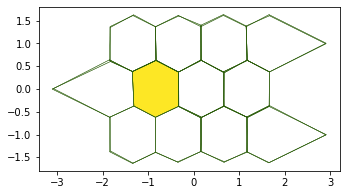

In [13]:
eptm.settings['threshold_length'] = 0.5

IH_transition(eptm, eptm.edge_df.index[-1])
RNRGeometry.update_all(eptm)
draw_spec['face']['color'] = eptm.face_df.area

#ipv.clear()
#fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
#fig